# Visualise the node & edge predictions & perform dimensionality reduction:

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import torch
from sklearn.manifold import TSNE


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grace.base import GraphAttrs
from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor

from grace.evaluation.visualisation import (
    read_patch_stack_by_label, 
    montage_from_image_patches,
    overlay_from_image_patches,
)
from grace.evaluation.process import (
    generate_ground_truth_graph,
    assume_dummy_predictions_from_annotations,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load the train & test example images:

In [3]:
grace_path = Path("/Users/kulicna/Desktop/dataset/shape_stars/train")
grace_path.is_dir()

True

### Load the ResNet-152 to transform the data:

In [4]:
patch_size = (224, 224)
feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
feature_extractor = FeatureExtractor(model=feature_extractor, bbox_size=patch_size)


In [5]:
image_graph_dataset = ImageGraphDataset(
    image_dir=grace_path,
    grace_dir=grace_path,
    transform=feature_extractor,
    keep_unknown_labels=False
)

In [6]:
image, target = image_graph_dataset[1]
graph = target['graph']

Node count | before relabelling = [56, 84, 38] | after relabelling = [94, 84, 0] | [0.5280898876404494, 0.47191011235955055, 0.0] %
Edge count | before relabelling = [204, 100, 211] | after relabelling = [415, 100, 0] | [0.8058252427184466, 0.1941747572815534, 0.0] %


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


### Visualise:

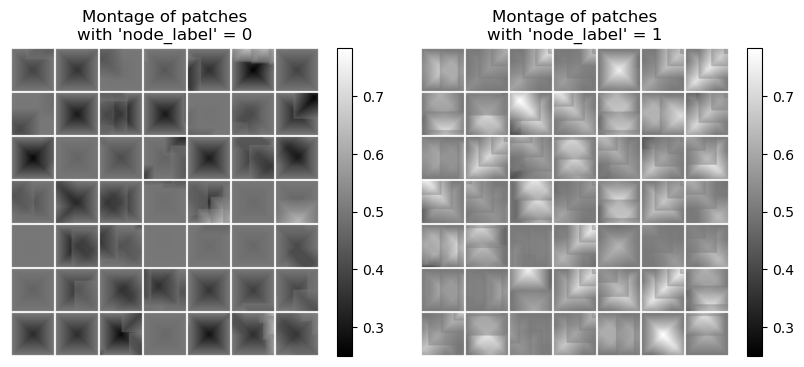

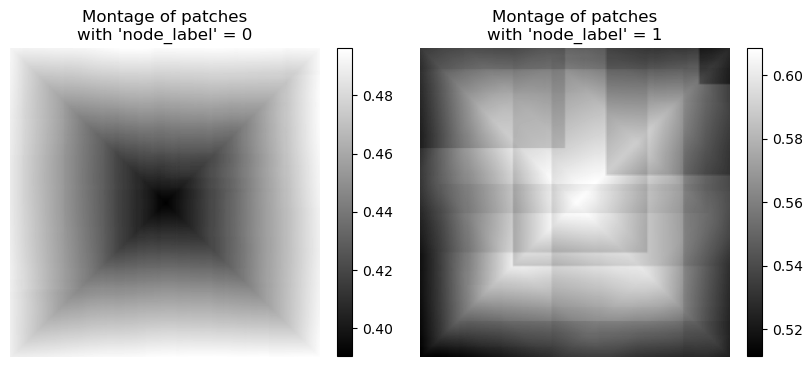

In [7]:
crops = read_patch_stack_by_label(G=graph, image=image, crop_shape=patch_size)
montage_from_image_patches(crops)
overlay_from_image_patches(crops)

### Perform the TSNE:

In [8]:
node_GT_label = []
node_features = []

for idx, node in graph.nodes(data=True):
    node_GT_label.append(node[GraphAttrs.NODE_GROUND_TRUTH].value)
    node_features.append(node[GraphAttrs.NODE_FEATURES].numpy())

node_GT_label = np.array(node_GT_label)
node_features = np.array(node_features)

In [9]:
node_embed = TSNE(n_components=2).fit_transform(X=node_features)
node_embed.shape


(178, 2)

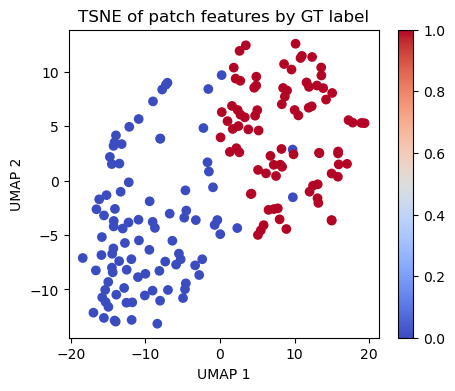

In [10]:
plt.figure(figsize=(5, 4))
umap1, umap2 = node_embed[:, 0], node_embed[:, 1]
plt.scatter(x=umap1, y=umap2, c=node_GT_label, cmap="coolwarm")
plt.colorbar()
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("TSNE of patch features by GT label")
plt.show()

### Visualise a histogram of the predictions:

In [11]:
def visualise_prediction_probs_hist(G: nx.Graph) -> None:
    """Plot the prediction probabilities colour-coded by their GT label."""

    # Process the true & pred values:
    n_true, n_pred = [], []
    for _, node in G.nodes(data=True):
        n_pred.append(node[GraphAttrs.NODE_PREDICTION])
        n_true.append(node[GraphAttrs.NODE_GROUND_TRUTH])

    e_true, e_pred = [], []
    for _, _, edge in G.edges(data=True):
        e_pred.append(edge[GraphAttrs.EDGE_PREDICTION])
        e_true.append(edge[GraphAttrs.EDGE_GROUND_TRUTH])

    # Plot the node & edge histogram by label:
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for i, (pred, true, att) in enumerate(zip(
            [n_pred, e_pred], [n_true, e_true], ["nodes", "edges"])):
        for l in np.unique(true):
            preds = [p for p, t in zip(pred, true) if t == l]
            axes[i].hist(preds, alpha=0.7, label=f"GT = {l} | {len(preds)} {att}")
            axes[i].set_title(f"Inferred {att} predictions")
            axes[i].set_xlabel("Predicted softmax probability")
            axes[i].legend()

    axes[0].set_ylabel("Attribute count")
    plt.show()


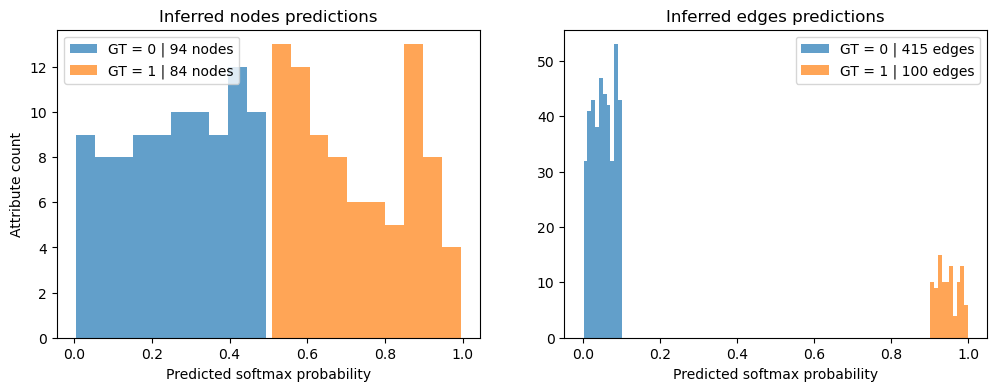

In [12]:
assume_dummy_predictions_from_annotations(graph)
visualise_prediction_probs_hist(graph)


### Visualise the predicted probabilities per-node & per-edge:

In [13]:
def visualise_node_and_edge_probabilities(G: nx.Graph) -> None:

    # Create a figure and axes
    nrows, ncols = 1, 3
    _, axes = plt.subplots(nrows, ncols, figsize=(15, 4))
    cmap = plt.cm.ScalarMappable(cmap='coolwarm')

    # JUST THE NODES:
    nodes = list(G.nodes(data=True))
    x_coords = [node[GraphAttrs.NODE_X] for _, node in nodes]
    y_coords = [node[GraphAttrs.NODE_Y] for _, node in nodes]
    node_preds = [node[GraphAttrs.NODE_PREDICTION] for _, node in nodes]
    
    # Plot nodes:
    axes[0].scatter(x=x_coords, y=y_coords, c=node_preds, cmap="coolwarm", vmin=0.0, vmax=1.0)
    axes[2].scatter(x=x_coords, y=y_coords, c=node_preds, cmap="coolwarm", vmin=0.0, vmax=1.0)
    
    # Add colorbar:
    cbar = plt.colorbar(cmap, ax=axes[0])
    cbar.set_label('Node Probability')

    # JUST THE EDGES:
    for src, dst, edge in G.edges(data=True):
        e_st_x, e_st_y = nodes[src][1][GraphAttrs.NODE_X], nodes[src][1][GraphAttrs.NODE_Y]
        e_en_x, e_en_y = nodes[dst][1][GraphAttrs.NODE_X], nodes[dst][1][GraphAttrs.NODE_Y]
        edge_pred = edge[GraphAttrs.EDGE_PREDICTION]
        
        # x_coords, y_coords = [edge_st[0], edge_en[0]], [edge_st[1], edge_en[1]]
        axes[1].plot([e_st_x, e_en_x], [e_st_y, e_en_y], color=cmap.to_rgba(edge_pred), marker='')
        axes[2].plot([e_st_x, e_en_x], [e_st_y, e_en_y], color=cmap.to_rgba(edge_pred), marker='')

    # Add colorbar
    cbar = plt.colorbar(cmap, ax=axes[1])
    cbar.set_label('Edge Probability')

    # Annotate & display:
    cbar = plt.colorbar(cmap, ax=axes[2])
    axes[0].set_title("Probability of 'nodeness'")
    axes[1].set_title("Probability of 'edgeness'")
    axes[2].set_title("Merged graph predictions")

    [axes[i].get_xaxis().set_visible(False) for i in range(ncols)]
    [axes[i].get_yaxis().set_visible(False) for i in range(ncols)]
    plt.tight_layout()
    plt.show()


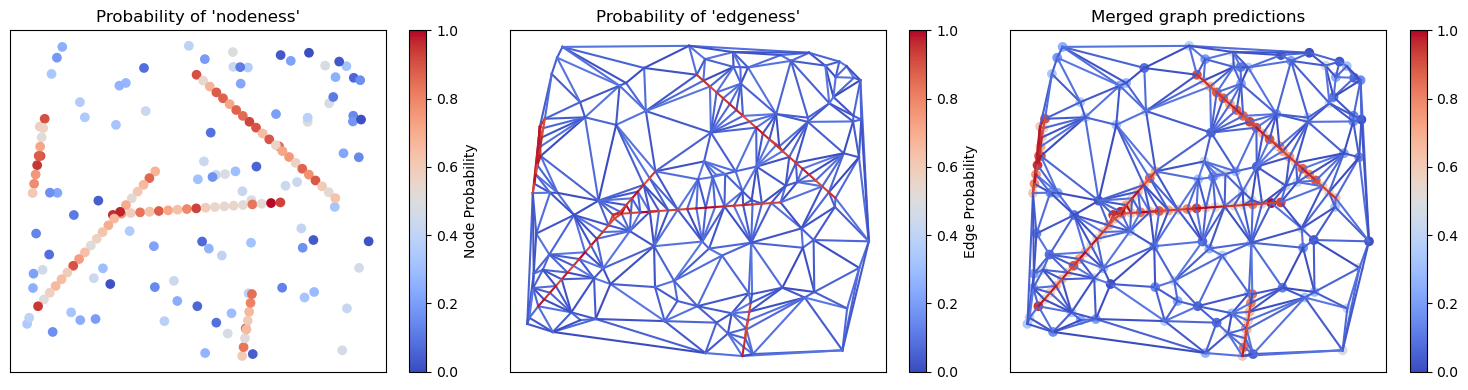

In [14]:
visualise_node_and_edge_probabilities(graph)

##### Done!